# Evolutionary computing
## Assignment III

### Table of Contents
* [Statement](##Statement)
    * [Libraries](###Libraries)
    * [3D surface](###3D_surface)
    * [Parameters](###Parameters)
* [Functions](##Functions)
    * [Binary representation](###Binary_representation)
    * [Real representation](###Real_representation)
    * [Common](###Common)
* [Executive](#Executive)
    * [Binary representation](###Binary_executive)
    * [Real representation](###Real_executive)
* [Results](#chapter3)
    * [Problem 1](#section_3_1)
        * [Sub Section 3.1.1](#sub_section_3_1_1)
        * [Sub Section 3.1.2](#sub_section_3_1_2)
    * [Problem 2](#section_3_2)
        * [Sub Section 3.2.1](#sub_section_3_2_1)

### Libraries

In [1]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-whitegrid') 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pandas as pd

from numba import jit, cuda 
import numpy as np
import random

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

import logging;
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
logging.disable(logging.WARNING)

### 3D_surface

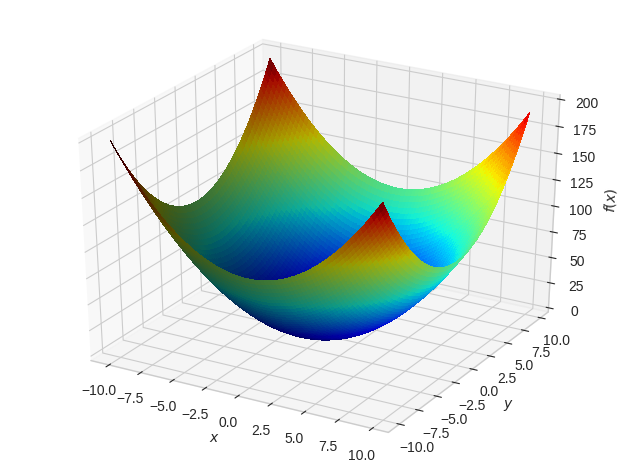

In [2]:
fig = plt.figure()
ax = fig.gca(projection='3d')

X=np.arange(-10,10,0.25)
Y=np.arange(-10,10,0.25)
X,Y = np.meshgrid(X,Y)
Z = X**2 + Y**2

my_col = cm.jet(Z/np.amax(Z))

surf = ax.plot_surface(X,Y,Z,linewidth=0,antialiased=False, rstride=1, cstride=1, facecolors = my_col)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$f(x)$')
fig.tight_layout()

plt.show()

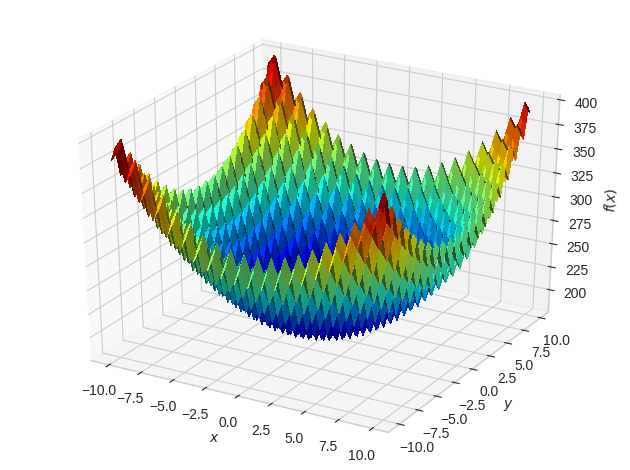

In [3]:
fig = plt.figure()
ax = fig.gca(projection='3d')

X=np.arange(-10,10,0.25)
Y=np.arange(-10,10,0.25)
X,Y = np.meshgrid(X,Y)
Z = 10*10 + X**2 - 10*np.cos(2*np.pi*X) + 10*10 + Y**2 - 10*np.cos(2*np.pi*Y)

surf = ax.plot_surface(X,Y,Z,linewidth=0,antialiased=False, rstride=1, cstride=1, facecolors = my_col)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$f(x)$')
fig.tight_layout()
plt.show()

### Parameters

In [4]:
'''Parámetros de entrada
'''
ppl_size = 100 #int(input("Tamaño de la población: "))
generations = 1000 #int(input("Número de generaciones: "))
p_crossover = 1.0 #float(input("Porcentaje de cruza: "))
p_mutation = 0.25 #float(input("Porcentaje de mutación: "))

max_evals = ppl_size*generations
uncertainty = 1.0

## Functions

### Binary_representation

In [5]:
@jit(target_backend='cuda')
def generateBinarySolution(case):
    if (case == 1):
        return np.random.randint(2, size=10*15)
    if (case == 2):
        return np.random.randint(2, size=10*14)

def deterministicSampling(population, apptitudes, no_parents):
    integers = []
    decimals = []
    net_fit = np.array(apptitudes).sum(axis=0)[1]
    for fit_i in apptitudes:
        expected = (fit_i[1]/net_fit)*len(population)
        i, d = divmod(expected, 1)
        decimals.append((fit_i[0],d))
        if (i == 1.0):
            integers.append(fit_i[0])
    decimals = sorted(decimals,key=lambda l:l[1], reverse=True)
    parents = []
    # Si hay suficientes 1 usarlos
    if (len(integers) >= no_parents):
        for cc in range(no_parents):
            indx = integers[cc]
            parents.append(population[indx])
    # Si no hay suficientes usar los que existan
    elif (len(integers) > 0 and len(integers) < no_parents):
        for dd in integers:
            parents.append(population[dd])
    kk = 0
    # Si faltan padres tomar de los decimales
    while (len(parents) < no_parents):
        parents.append(population[decimals[kk][0]])
        kk += 1
    return parents

@jit(target_backend='cuda')
def binaryCrossover(solution1, solution2):    
    cross_pt = random.randint(1, solution1.size-1)
    first_half1  = solution1[:cross_pt]
    second_half1 = solution1[cross_pt:]
    first_half2  = solution2[:cross_pt]
    second_half2 = solution2[cross_pt:]
    sol_1 = np.concatenate((first_half1,second_half2))
    sol_2 = np.concatenate((first_half2,second_half1))
    return sol_1, sol_2

@jit(target_backend='cuda')
def binaryMutation(solution):
    index = random.randint(1, solution.size-1)
    if (solution[index] == 0):
        solution[index] = 1
    else:
        solution[index] = 0
    return solution

### Real_representation

In [6]:
def generateRealSolution(case):
    if (case == 1):
        sol_1 = np.random.uniform(-10,10,10)
        return np.round(sol_1, decimals=3)
    if (case == 2):
        sol_2 = np.random.uniform(-5.12,5.12,10)
        return np.round(sol_2, decimals=3)

def deterministicTournament(population, apptitudes):
    indx_lst = random.sample(range(0, ppl_size), 4)
    parents_subset = []
    for indx in indx_lst:
        parents_subset.append(apptitudes[indx])
    parents_subset.sort(key=lambda a: a[1])
    index_1 = parents_subset[0][0]
    index_2 = parents_subset[1][0]
    parent_1 = population[index_1]
    parent_2 = population[index_2]
    return parent_1, parent_2

def realCrossover(good_solution,bad_solution,alpha,beta):
    H = []
    k = len(good_solution)
    for i in range(0, k):
        I = abs(good_solution[i] - bad_solution[i])
        if (good_solution[i] < bad_solution[i]):
            Li = good_solution[i] - alpha*I
            Ls = bad_solution[i] + beta*I
        else:
            Li = bad_solution[i] - beta*I
            Ls = good_solution[i] + alpha*I
        h_i = np.random.uniform(Li,Ls)
        H.append(h_i)
    son = np.array(H)
    return np.round(son, decimals=3)

def realMutation(solution, case):
    if (case ==1):
        Linf = -10
        Lsup = 10
    if (case ==2):
        Linf = -5.12
        Lsup = 5.12
    index = random.randint(1, solution.size-1)
    solution[index] = np.random.uniform(Linf,Lsup,1)[0]
    return np.round(solution, decimals=3)

### Common

In [7]:
@jit(target_backend='cuda')
def decodeBin2Real(binSolution, case):
    if (case ==1):
        Linf = -10
        Lsup = 10
        L = 15
    if (case ==2):
        Linf = -5.12
        Lsup = 5.12
        L = 14
    split_indx = 0
    d_splits = np.split(binSolution, 10)
    RealSolution = []
    while (split_indx < 10):
        local_indx = 0
        x_integer = 0
        x = d_splits[split_indx]
        while (local_indx<L):
            if (x[local_indx] ==1):
                x_integer += local_indx**2
            local_indx += 1
        x_real = Linf + (x_integer*(Lsup - Linf))/(2**L - 1)
        RealSolution.append(x_real)
        split_indx += 1
    return np.array(RealSolution)

@jit(target_backend='cuda')
def fitness(x, case, isBin = False):
    if (isBin == True):
        x = decodeBin2Real(x,case)  
    if (case == 1):
        fit = np.sum(x**2)
    if (case == 2):
        fit = 10*10 + np.sum(x**2 - 10*np.cos(2*np.pi*x)) 
    return np.round(fit, decimals=3)

@jit(target_backend='cuda')
def generatePopulation(size, case, isBin):
    population = []
    apptitudes = []
    for index in range (0,size):
        if (isBin == True):
            solution = generateBinarySolution(case)
        else:
            solution = generateRealSolution(case)
            solution = np.round(solution, decimals=3)
        apptitude = fitness(solution,case,isBin)
        apptitudes.append((index,apptitude))
        population.append(solution)
    return population, apptitudes

## Executive

### Binary_executive

In [8]:
def executeBinaryRepresentation(c, printScore):
    bestApptitude = []
    averageApptitude = []
    best_solution = 0
    population, apptitudes = generatePopulation(ppl_size,case=c,isBin=False)
    evals = 0
    gens = 0
    while (evals < max_evals):
        no_parents = 10
        midle_indx = int(no_parents/2)
        parents = deterministicSampling(population, apptitudes, no_parents)
        sons_a = []
        sons_b = []
        pc = np.random.uniform(0,1,1)[0]
        if (pc <= p_crossover):
            for i in range(midle_indx):
                son_a, son_b = binaryCrossover(parents[i], parents[midle_indx+i])                
                sons_a.append(son_a)
                sons_b.append(son_b)
        else:
            for i in range(midle_indx):
                sons_a.append(parents[i])
                sons_b.append(parents[midle_indx+i])

        pm = np.random.uniform(0,1,1)[0]
        if (pm <= p_mutation):
            for i in range(midle_indx):
                sons_a[i] = binaryMutation(sons_a[i])
                sons_b[i] = binaryMutation(sons_b[i])

        for i in range(midle_indx):
            population.append(sons_a[i])
            population.append(sons_b[i])

        nuevas_aptitudes = []
        for index in range (0,len(population)):
            apptitude = fitness(population[index],case=c,isBin=False)
            nuevas_aptitudes.append((index,apptitude))

        nuevas_aptitudes.sort(key=lambda a: a[1])

        nueva_poblacion = []
        for i in nuevas_aptitudes:
            nueva_poblacion.append(population[i[0]])

        nuevas_aptitudes.clear()
        nueva_poblacion = nueva_poblacion[:ppl_size]     
        average_fit = 0
        for i in range(0,len(nueva_poblacion)):
            apptitude = fitness(nueva_poblacion[i],case=c,isBin=False)
            average_fit += apptitude
            nuevas_aptitudes.append((i,apptitude))
            evals += 1
        population = nueva_poblacion
        apptitudes = nuevas_aptitudes
        average_fit = average_fit/ppl_size
        bestApptitude.append(apptitudes[0][1])
        averageApptitude.append(average_fit)
        if (evals % ppl_size == 0):
            gens += 1
            if (printScore == True):
                print(population[apptitudes[0][0]], "f(x)", apptitudes[0][1], "Gen", gens)
        if (apptitudes[0][1] < uncertainty):
            break
    return bestApptitude, averageApptitude

In [9]:
bbest_appt_1, avg_appt_1 = executeBinaryRepresentation(1, True)

/tmp/ipykernel_16708/3814991739.py:37: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "generatePopulation" failed type inference due to: Untyped global name 'generateRealSolution': Cannot determine Numba type of <class 'function'>

File "../../../../../../../tmp/ipykernel_16708/3814991739.py", line 45:
<source missing, REPL/exec in use?>

  @jit(target_backend='cuda')
/tmp/ipykernel_16708/3814991739.py:37: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "generatePopulation" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "../../../../../../../tmp/ipykernel_16708/3814991739.py", line 41:
<source missing, REPL/exec in use?>

  @jit(target_backend='cuda')
/home/jhermosilla/.local/lib/python3.8/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "generatePopulation" was compiled in object mode withou

[-5.161 -0.199  0.796 -3.641  1.683  1.955 -4.95  -3.597  3.563  1.117] f(x) 98.604 Gen 1
[-5.161 -0.199  0.796 -3.641  1.683  1.955 -4.95  -3.597  3.563  1.117] f(x) 98.604 Gen 2
[-5.161 -0.199  0.796 -3.641  1.683  1.955 -4.95  -3.597  3.563  1.117] f(x) 98.604 Gen 3
[-5.161 -0.199  0.796 -3.641  1.683  1.955 -4.95  -3.597  3.563  1.117] f(x) 98.604 Gen 4
[-5.161 -0.199  0.796 -3.641  1.683  1.955 -4.95  -3.597  3.563  1.117] f(x) 98.604 Gen 5
[-5.161 -0.199  0.796 -3.641  1.683  1.955 -4.95  -3.597  3.563  1.117] f(x) 98.604 Gen 6
[-5.161 -0.199  0.796 -3.641  1.683  1.955 -4.95  -3.597  3.563  1.117] f(x) 98.604 Gen 7
[-5.161 -0.199  0.796 -3.641  1.683  1.955 -4.95  -3.597  3.563  1.117] f(x) 98.604 Gen 8
[-5.161 -0.199  0.796 -3.641  1.683  1.955 -4.95  -3.597  3.563  1.117] f(x) 98.604 Gen 9
[-5.161 -0.199  0.796 -3.641  1.683  1.955 -4.95  -3.597  3.563  1.117] f(x) 98.604 Gen 10
[-5.161 -0.199  0.796 -3.641  1.683  1.955 -4.95  -3.597  3.563  1.117] f(x) 98.604 Gen 11
[-5.161 

In [10]:
bbest_appt_2, avg_appt_2 = executeBinaryRepresentation(2, True)

[ 0.963  0.279 -3.723  2.111  0.849 -0.117  2.069  0.234 -2.886 -4.   ] f(x) 93.96 Gen 1
[ 0.963  0.279 -3.723  2.111  0.849 -0.117  2.069  0.234 -2.886 -4.   ] f(x) 93.96 Gen 2
[ 0.963  0.279 -3.723  2.111  0.849 -0.117  2.069  0.234 -2.886 -4.   ] f(x) 93.96 Gen 3
[ 0.963  0.279 -3.723  2.111  0.849 -0.117  2.069  0.234 -2.886 -4.   ] f(x) 93.96 Gen 4
[ 0.963  0.279 -3.723  2.111  0.849 -0.117  2.069  0.234 -2.886 -4.   ] f(x) 93.96 Gen 5
[ 0.963  0.279 -3.723  2.111  0.849 -0.117  2.069  0.234 -2.886 -4.   ] f(x) 93.96 Gen 6
[ 0.963  0.279 -3.723  2.111  0.849 -0.117  2.069  0.234 -2.886 -4.   ] f(x) 93.96 Gen 7
[ 0.963  0.279 -3.723  2.111  0.849 -0.117  2.069  0.234 -2.886 -4.   ] f(x) 93.96 Gen 8
[ 0.963  0.279 -3.723  2.111  0.849 -0.117  2.069  0.234 -2.886 -4.   ] f(x) 93.96 Gen 9
[ 0.963  0.279 -3.723  2.111  0.849 -0.117  2.069  0.234 -2.886 -4.   ] f(x) 93.96 Gen 10
[ 0.963  0.279 -3.723  2.111  0.849 -0.117  2.069  0.234 -2.886 -4.   ] f(x) 93.96 Gen 11
[ 0.963  0.279 -3.7

### Real_executive

In [11]:
def executeRealRepresentation(c, printScore):
    bestApptitude = []
    averageApptitude = []
    best_solution = 0
    population, apptitudes = generatePopulation(ppl_size,case=c,isBin=False)
    evals = 0
    gens = 0
    while (evals < max_evals):
        parent_1, parent_2 = deterministicTournament(population, apptitudes)
        fit_1 = fitness(parent_1,case=c,isBin=False)
        fit_2 = fitness(parent_2,case=c,isBin=False)
        if (fit_1 < fit_2):
            son_1 = realCrossover(parent_1, parent_2, 0.5, 0.5)
            son_2 = realCrossover(parent_1, parent_2, 0.5, 0.5)
        else: 
            son_1 = realCrossover(parent_2, parent_1, 0.5, 0.5)
            son_2 = realCrossover(parent_2, parent_1, 0.5, 0.5)

        pm = np.random.uniform(0,1,1)[0]
        if (pm <= p_mutation):
            son_1 = realMutation(son_1,c)
            son_2 = realMutation(son_2,c)
        else:
            son_1, son_2 = parent_1, parent_2

        population.append(son_1)
        population.append(son_2)

        nuevas_aptitudes = []
        for index in range (0,len(population)):
            apptitude = fitness(population[index],case=c,isBin=False)
            nuevas_aptitudes.append((index,apptitude))

        nuevas_aptitudes.sort(key=lambda a: a[1])

        nueva_poblacion = []
        for i in nuevas_aptitudes:
            nueva_poblacion.append(population[i[0]])

        nuevas_aptitudes.clear()
        nueva_poblacion = nueva_poblacion[:ppl_size]     
        average_fit = 0
        for i in range(0,len(nueva_poblacion)):
            apptitude = fitness(nueva_poblacion[i],case=c,isBin=False)
            average_fit += apptitude
            nuevas_aptitudes.append((i,apptitude))
            evals += 1
        population = nueva_poblacion
        apptitudes = nuevas_aptitudes
        average_fit = average_fit/ppl_size
        bestApptitude.append(apptitudes[0][1])
        averageApptitude.append(average_fit)
        if (evals % ppl_size == 0):
            gens += 1
            if (printScore == True):
                print(population[apptitudes[0][0]], "f(x)", apptitudes[0][1], "Gen", gens)
        if (apptitudes[0][1] < uncertainty):
            break
    return bestApptitude, averageApptitude

In [12]:
bbest_appt_3, avg_appt_3 = executeRealRepresentation(1, True)

[ 2.829 -1.969  1.684 -0.354 -1.819 -4.961  1.378  1.425 -2.544  5.362] f(x) 81.914 Gen 1
[ 2.829 -1.969  1.684 -0.354 -1.819 -4.961  1.378  1.425 -2.544  5.362] f(x) 81.914 Gen 2
[ 2.829 -1.969  1.684 -0.354 -1.819 -4.961  1.378  1.425 -2.544  5.362] f(x) 81.914 Gen 3
[ 2.829 -1.969  1.684 -0.354 -1.819 -4.961  1.378  1.425 -2.544  5.362] f(x) 81.914 Gen 4
[ 2.829 -1.969  1.684 -0.354 -1.819 -4.961  1.378  1.425 -2.544  5.362] f(x) 81.914 Gen 5
[ 2.829 -1.969  1.684 -0.354 -1.819 -4.961  1.378  1.425 -2.544  5.362] f(x) 81.914 Gen 6
[ 2.829 -1.969  1.684 -0.354 -1.819 -4.961  1.378  1.425 -2.544  5.362] f(x) 81.914 Gen 7
[ 2.829 -1.969  1.684 -0.354 -1.819 -4.961  1.378  1.425 -2.544  5.362] f(x) 81.914 Gen 8
[ 2.829 -1.969  1.684 -0.354 -1.819 -4.961  1.378  1.425 -2.544  5.362] f(x) 81.914 Gen 9
[ 2.829 -1.969  1.684 -0.354 -1.819 -4.961  1.378  1.425 -2.544  5.362] f(x) 81.914 Gen 10
[ 2.829 -1.969  1.684 -0.354 -1.819 -4.961  1.378  1.425 -2.544  5.362] f(x) 81.914 Gen 11
[ 2.829 

In [13]:
bbest_appt_4, avg_appt_4 = executeRealRepresentation(2, True)

[-0.877  2.236 -2.782 -4.118 -0.838 -3.729 -1.211  2.101 -2.141  2.925] f(x) 117.033 Gen 1
[-0.877  2.236 -2.782 -4.118 -0.838 -3.729 -1.211  2.101 -2.141  2.925] f(x) 117.033 Gen 2
[-0.877  2.236 -2.782 -4.118 -0.838 -3.729 -1.211  2.101 -2.141  2.925] f(x) 117.033 Gen 3
[-0.877  2.236 -2.782 -4.118 -0.838 -3.729 -1.211  2.101 -2.141  2.925] f(x) 117.033 Gen 4
[-0.877  2.236 -2.782 -4.118 -0.838 -3.729 -1.211  2.101 -2.141  2.925] f(x) 117.033 Gen 5
[-0.877  2.236 -2.782 -4.118 -0.838 -3.729 -1.211  2.101 -2.141  2.925] f(x) 117.033 Gen 6
[-0.877  2.236 -2.782 -4.118 -0.838 -3.729 -1.211  2.101 -2.141  2.925] f(x) 117.033 Gen 7
[-0.877  2.236 -2.782 -4.118 -0.838 -3.729 -1.211  2.101 -2.141  2.925] f(x) 117.033 Gen 8
[-0.877  2.236 -2.782 -4.118 -0.838 -3.729 -1.211  2.101 -2.141  2.925] f(x) 117.033 Gen 9
[-0.877  2.236 -2.782 -4.118 -0.838 -3.729 -1.211  2.101 -2.141  2.925] f(x) 117.033 Gen 10
[-0.877  2.236 -2.782 -4.118 -0.838 -3.729 -1.211  2.101 -2.141  2.925] f(x) 117.033 Gen 

In [14]:
history_1B = []
history_1R = []
history_2B = []
history_2R = []

record_1B = []
record_1R = []
record_2B = []
record_2R = []

for i in range(30):
    bbest_appt_1B, _ = executeBinaryRepresentation(1, False)
    bbest_appt_1R, _ = executeRealRepresentation(1, False)
    bbest_appt_2B, _ = executeBinaryRepresentation(2, False)
    bbest_appt_2R, _ = executeRealRepresentation(2, False)

    history_1B.append([i,bbest_appt_1B[-1]])
    record_1B.append(bbest_appt_1B)
    history_1R.append([i,bbest_appt_1R[-1]])
    record_1R.append(bbest_appt_1R)
    history_2B.append([i,bbest_appt_2B[-1]])
    record_2B.append(bbest_appt_2B)
    history_2R.append([i,bbest_appt_2R[-1]])
    record_2R.append(bbest_appt_2R)

In [15]:
history_1R_np = np.array(history_1R)
max_1R = np.max(history_1R_np, axis=0)[1]
min_1R = np.min(history_1R_np, axis=0)[1]

best_1R = history_1R_np[np.where(history_1R_np[:,1] == min_1R)]
worst1R = history_1R_np[np.where(history_1R_np[:,1] == max_1R)]
mean_1R = np.mean(history_1R_np[:,1])
median1R = np.median(history_1R_np[:,1])
std_1R = np.std(history_1R_np[:,1])

history_1B_np = np.array(history_1B)
max_1B = np.max(history_1B_np, axis=0)[1]
min_1B = np.min(history_1B_np, axis=0)[1]

best_1B = history_1B_np[np.where(history_1B_np[:,1] == min_1B)]
worst1B = history_1B_np[np.where(history_1B_np[:,1] == max_1B)]
mean_1B = np.mean(history_1B_np[:,1])
median1B = np.median(history_1B_np[:,1])
std_1B = np.std(history_1B_np[:,1])

problem_1 = {'Binary': pd.Series([best_1B[0,1], worst1B[0,1], mean_1B, median1B, std_1B],
                      index=['best', 'worst', 'mean', 'median', 'sdt']),
            'Real': pd.Series([best_1R[0,1], worst1R[0,1], mean_1R, median1R, std_1R],
                      index=['best', 'worst', 'mean', 'median', 'sdt'])}
 
problem_1_df = pd.DataFrame(problem_1)
print("Problem 1")
print(problem_1_df)

Problem 1
          Binary       Real
best    0.010000   1.417000
worst   0.985000  28.347000
mean    0.552600   7.078667
median  0.526000   5.133000
sdt     0.280637   5.954044


In [16]:
history_2R_np = np.array(history_2R)
max_2R = np.max(history_2R_np, axis=0)[1]
min_2R = np.min(history_2R_np, axis=0)[1]

best_2R = history_2R_np[np.where(history_2R_np[:,1] == min_2R)]
worst2R = history_2R_np[np.where(history_2R_np[:,1] == max_2R)]
mean_2R = np.mean(history_2R_np[:,1])
median2R = np.median(history_2R_np[:,1])
std_2R = np.std(history_2R_np[:,1])

history_2B_np = np.array(history_2B)
max_2B = np.max(history_2B_np, axis=0)[1]
min_2B = np.min(history_2B_np, axis=0)[1]

best_2B = history_2B_np[np.where(history_2B_np[:,1] == min_2B)]
worst2B = history_2B_np[np.where(history_2B_np[:,1] == max_2B)]
mean_2B = np.mean(history_2B_np[:,1])
median2B = np.median(history_2B_np[:,1])
std_2B = np.std(history_2B_np[:,1])

problem_2 = {'Binary': pd.Series([best_2B[0,1], worst2B[0,1], mean_2B, median2B, std_2B],
                      index=['best', 'worst', 'mean', 'median', 'sdt']),
            'Real': pd.Series([best_2R[0,1], worst2R[0,1], mean_2R, median2R, std_2R],
                      index=['best', 'worst', 'mean', 'median', 'sdt'])}
 
problem_2_df = pd.DataFrame(problem_2)
print("Problem 2")
print(problem_2_df)

Problem 2
          Binary       Real
best    0.000000  17.142000
worst   4.090000  49.331000
mean    1.217200  29.803267
median  1.017000  29.262500
sdt     1.019125   7.752484


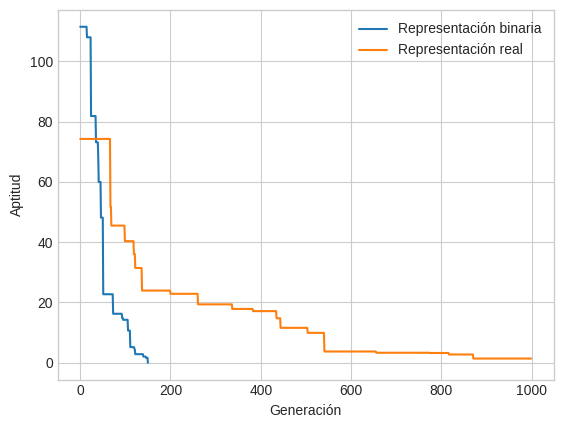

In [17]:
plt.plot(record_1B[int(best_1B[0,0])], label='Representación binaria')
plt.plot(record_1R[int(best_1R[0,0])], label='Representación real')

plt.xlabel("Generación")
plt.ylabel("Aptitud")
plt.legend() 
plt.show()

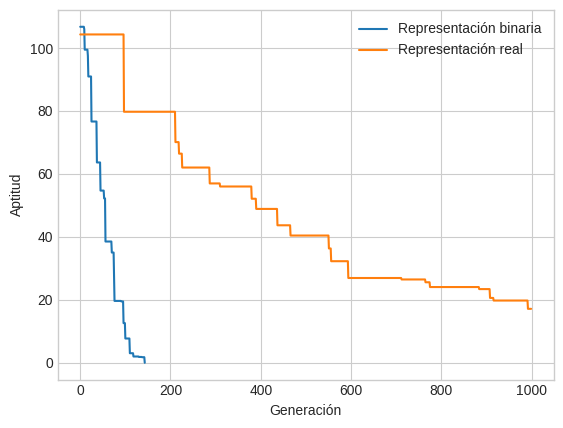

In [18]:
plt.plot(record_2B[int(best_2B[0,0])], label='Representación binaria')
plt.plot(record_2R[int(best_2R[0,0])], label='Representación real')

plt.xlabel("Generación")
plt.ylabel("Aptitud")
plt.legend() 
plt.show()